# Sales Forecasting for a High-Performing Product Using Time Series Analysis

In [211]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [212]:
def plot_decomposition(original, decomposition):
    plt.figure(figsize=(6, 5))

    ax1 = plt.subplot(4, 1, 1)
    plt.plot(original, label="Original", color="C0", lw=1)
    plt.ylabel("Original")

    plt.subplot(4, 1, 2, sharex=ax1)
    plt.plot(decomposition.trend, label="Trend", color="C1", lw=1)
    plt.ylabel("Trend")

    plt.subplot(4, 1, 3, sharex=ax1)
    plt.plot(decomposition.seasonal, label="Seasonal", color="C2", lw=1)
    plt.ylabel("Seasonal")

    plt.subplot(4, 1, 4, sharex=ax1)
    plt.plot(decomposition.resid, label="Residual", color="C3", lw=1)
    plt.ylabel("Residual")

    plt.tight_layout()

In [ ]:
def MAPE(predicted, actual):
    mape = np.abs(predicted - actual) / actual
    return np.mean(mape) * 100

## 1. Introduction

The goal of this project is to conduct an exploratory data analysis (EDA) on a dataset containing weekly sales of health supplements, identify the top-selling product with highest revenue, and forecast its future sales using Time Series modeling techniques such as ARIMA or SARIMA. These models are widely used in the retail industry to forecast sales, detect seasonal demand patterns, and optimize inventory management. 

## 2. Dataset

In [270]:
dataset = pd.read_csv('Supplement_Sales_Weekly_Expanded.csv')

This dataset contains weekly sales data for a variety of health and wellness supplements from January 1, 2020, to March 31, 2025. The dataset consists of 4,384 rows and 10 columns. Each row represents weekly sales data for one of the 16 products.

In [271]:
dataset.shape

(4384, 10)

In [272]:
dataset.head()

,Date,Product Name,Category,Units Sold,Price,Revenue,Discount,Units Returned,Location,Platform
0,2020-01-06,Whey Protein,Protein,143,31.98,4573.14,0.03,2,Canada,Walmart
1,2020-01-06,Vitamin C,Vitamin,139,42.51,5908.89,0.04,0,UK,Amazon
2,2020-01-06,Fish Oil,Omega,161,12.91,2078.51,0.25,0,Canada,Amazon
3,2020-01-06,Multivitamin,Vitamin,140,16.07,2249.80,0.08,0,Canada,Walmart
4,2020-01-06,Pre-Workout,Performance,157,35.47,5568.79,0.25,3,Canada,iHerb


In [273]:
dataset.tail()

,Date,Product Name,Category,Units Sold,Price,Revenue,Discount,Units Returned,Location,Platform
4379,2025-03-31,Melatonin,Sleep Aid,160,47.79,7646.40,0.21,1,USA,iHerb
4380,2025-03-31,Biotin,Vitamin,154,38.12,5870.48,0.22,1,UK,Walmart
4381,2025-03-31,Green Tea Extract,Fat Burner,139,20.40,2835.60,0.12,3,USA,iHerb
4382,2025-03-31,Iron Supplement,Mineral,154,18.31,2819.74,0.23,2,Canada,Amazon
4383,2025-03-31,Electrolyte Powder,Hydration,178,39.12,6963.36,0.23,0,UK,iHerb


The data includes information about Product Name, Category, Units Sold, Price (in USD), Revenue (calculated as Units Sold x Price), Discount, Units Returned, Location, and Platform.

In [218]:
dataset.columns

Index(['Date', 'Product Name', 'Category', 'Units Sold', 'Price', 'Revenue',
       'Discount', 'Units Returned', 'Location', 'Platform'],
      dtype='object')

In [219]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4384 entries, 0 to 4383
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            4384 non-null   object 
 1   Product Name    4384 non-null   object 
 2   Category        4384 non-null   object 
 3   Units Sold      4384 non-null   int64  
 4   Price           4384 non-null   float64
 5   Revenue         4384 non-null   float64
 6   Discount        4384 non-null   float64
 7   Units Returned  4384 non-null   int64  
 8   Location        4384 non-null   object 
 9   Platform        4384 non-null   object 
dtypes: float64(3), int64(2), object(5)
memory usage: 342.6+ KB


In [274]:
dataset.describe()

,Units Sold,Price,Revenue,Discount,Units Returned
count,4384.000000,4384.000000,4384.000000,4384.000000,4384.000000
mean,150.200274,34.781229,5226.569446,0.124398,1.531478
std,12.396099,14.198309,2192.491946,0.071792,1.258479
min,103.000000,10.000000,1284.000000,0.000000,0.000000
25%,142.000000,22.597500,3349.372500,0.060000,1.000000
50%,150.000000,34.720000,5173.140000,0.120000,1.000000
75%,158.000000,46.712500,7009.960000,0.190000,2.000000
max,194.000000,59.970000,10761.850000,0.250000,8.000000


Checking for missing data, outliers, and unusual values in the dataset.

In [221]:
dataset.isna().sum()

Date              0
Product Name      0
Category          0
Units Sold        0
Price             0
Revenue           0
Discount          0
Units Returned    0
Location          0
Platform          0
dtype: int64

The Product Name column includes 16 products, each with 274 rows, which is corresponds to the number of weeks in the given period of time (from January 2020 through March 2025).

In [222]:
# 16 products names
dataset['Product Name'].value_counts().sort_index(), dataset['Product Name'].value_counts().count()

(Product Name
 Ashwagandha           274
 BCAA                  274
 Biotin                274
 Collagen Peptides     274
 Creatine              274
 Electrolyte Powder    274
 Fish Oil              274
 Green Tea Extract     274
 Iron Supplement       274
 Magnesium             274
 Melatonin             274
 Multivitamin          274
 Pre-Workout           274
 Vitamin C             274
 Whey Protein          274
 Zinc                  274
 Name: count, dtype: int64,
 np.int64(16))

The Category column includes 10 categories. Some categories have more products than others. For example, Omega has only 1 product, while Protein and Performance have 2 products, and Vitamin and Mineral have 3 products. 

In [223]:
# 10 products categories
dataset['Category'].value_counts().sort_values(), dataset['Category'].value_counts().count()

(Category
 Omega          274
 Amino Acid     274
 Herbal         274
 Sleep Aid      274
 Fat Burner     274
 Hydration      274
 Protein        548
 Performance    548
 Vitamin        822
 Mineral        822
 Name: count, dtype: int64,
 np.int64(10))

Looking closer at specific categories: Omega and Hydration each contain a single product — Fish Oil and Electrolyte Powder, respectively.

In [224]:
# 1 product in category Omega and Hydration
dataset.query("Category == 'Omega'")['Product Name'].unique(), dataset.query("Category == 'Hydration'")['Product Name'].unique()

(array(['Fish Oil'], dtype=object),
 array(['Electrolyte Powder'], dtype=object))

The categories Protein and Performance both include 2 products. The Protein has Whey Protein and Collagen Peptides. The Performance has Pre-Workout and Creatine.

In [225]:
# 2 products in category Protein and Performance  
dataset.query("Category == 'Protein'")['Product Name'].unique(), dataset.query("Category == 'Performance'")['Product Name'].unique()

(array(['Whey Protein', 'Collagen Peptides'], dtype=object),
 array(['Pre-Workout', 'Creatine'], dtype=object))

The Vitamin and Mineral categories each have three products. The Vitamin category contains Vitamin C, Multivitamin, and Biotin. The Mineral category contains Zinc, Magnesium, and Iron Supplement.

In [226]:
# 3 products in category Vitamin and Mineral
dataset.query("Category == 'Vitamin'")['Product Name'].unique(), dataset.query("Category == 'Mineral'")['Product Name'].unique()

(array(['Vitamin C', 'Multivitamin', 'Biotin'], dtype=object),
 array(['Zinc', 'Magnesium', 'Iron Supplement'], dtype=object))

For each weekly date, we have 16 rows, as expected.

In [227]:
dataset['Date'].value_counts().sort_index(), dataset['Date'].value_counts().count()

(Date
 2020-01-06    16
 2020-01-13    16
 2020-01-20    16
 2020-01-27    16
 2020-02-03    16
               ..
 2025-03-03    16
 2025-03-10    16
 2025-03-17    16
 2025-03-24    16
 2025-03-31    16
 Name: count, Length: 274, dtype: int64,
 np.int64(274))

Weekly revenue per product ranges from $1,284 to $10,761.

In [228]:
dataset['Revenue'].value_counts().sort_index(), dataset['Revenue'].value_counts().count()

(Revenue
 1284.00     1
 1352.61     1
 1354.50     1
 1358.08     1
 1379.04     1
            ..
 10248.60    1
 10254.18    1
 10297.32    1
 10686.30    1
 10761.85    1
 Name: count, Length: 4326, dtype: int64,
 np.int64(4326))

For later analysis, I set Date as the index and created two new columns — Month and Year.

In [229]:
dataset['Date'] = pd.to_datetime(dataset['Date'])

In [230]:
dataset.set_index('Date', inplace=True)
dataset.index

DatetimeIndex(['2020-01-06', '2020-01-06', '2020-01-06', '2020-01-06',
               '2020-01-06', '2020-01-06', '2020-01-06', '2020-01-06',
               '2020-01-06', '2020-01-06',
               ...
               '2025-03-31', '2025-03-31', '2025-03-31', '2025-03-31',
               '2025-03-31', '2025-03-31', '2025-03-31', '2025-03-31',
               '2025-03-31', '2025-03-31'],
              dtype='datetime64[ns]', name='Date', length=4384, freq=None)

In [231]:
dataset['Month'] = dataset.index.month
dataset['Year'] = dataset.index.year

## 3. Exploratory Data Analysis (EDA)

Before identifying the top-selling product for forecasting, I first examined revenue across all product categories. Let’s look first at Total Weekly and Monthly Revenue for all 16 Products.

In [232]:
grouped_by_date = dataset.groupby('Date')
grouped_by_date['Revenue'].sum()

Date
2020-01-06    71848.56
2020-01-13    72416.18
2020-01-20    76152.42
2020-01-27    70306.73
2020-02-03    98011.64
                ...   
2025-03-03    66065.44
2025-03-10    92509.57
2025-03-17    65590.53
2025-03-24    69778.44
2025-03-31    81915.03
Name: Revenue, Length: 274, dtype: float64

The first plot shows the total weekly revenue for all products. The data shows high volatility, likely influenced by promotions, holidays, or other events that can cause sharp spikes or drops in revenue. Despite this fluctuation, most weekly revenue values fall between $70,000 and $100,000. Also, the data has occasional outliers, both high and low, but there is no clear long-term upward or downward trend.

To reduce volatility and highlight patterns, I aggregated revenue by months. Monthly revenue consistently ranges between $330,000 and $440,000, with more noticeable and understandable peaks and drops, making the trend easier to interpret. These fluctuations may be explained by seasonal effects or periodic marketing campaigns. 

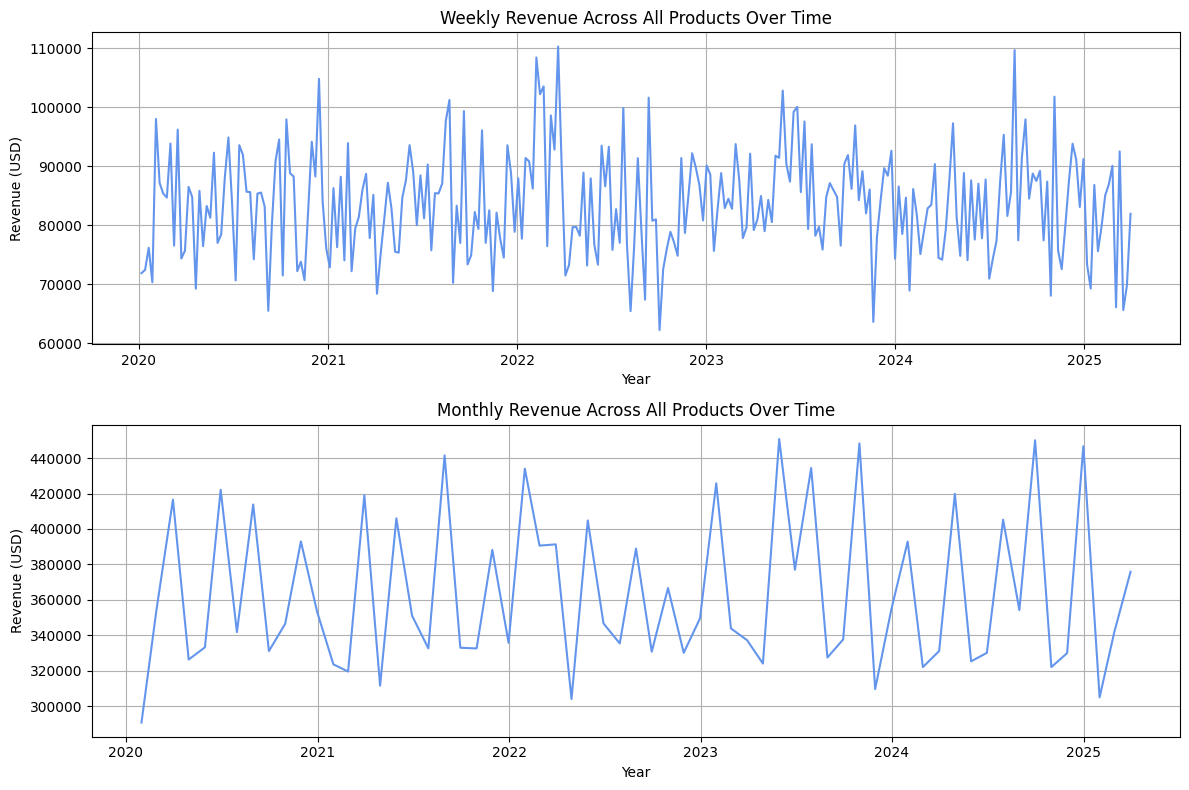

In [233]:
# Weekly Revenue Plot
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))

ax1.plot(grouped_by_date['Revenue'].sum(), alpha=1, color='cornflowerblue')
ax1.set_title('Weekly Revenue Across All Products Over Time')
ax1.set_xlabel('Year')
ax1.set_ylabel('Revenue (USD)')
ax1.grid(True)

# Monthly Revenue Plot
ax2.plot(dataset['Revenue'].resample('ME').sum(), alpha=1, color='cornflowerblue')
ax2.set_title('Monthly Revenue Across All Products Over Time')
ax2.set_xlabel('Year')
ax2.set_ylabel('Revenue (USD)')
ax2.grid(True)

plt.tight_layout()

In [234]:
grouped_by_year = dataset.groupby('Year')
revenue_grouped_by_year = grouped_by_year['Revenue'].sum()
revenue_grouped_by_year

Year
2020    4323393.22
2021    4294248.17
2022    4372808.55
2023    4470870.75
2024    4429367.35
2025    1022592.41
Name: Revenue, dtype: float64

The next plot demonstrates yearly revenue for all products. The highest-revenue year was 2023. Given that the dataset covers sales from January 2020 to the end of March 2025, a significant drop in early 2025 is expected because the year is incomplete.

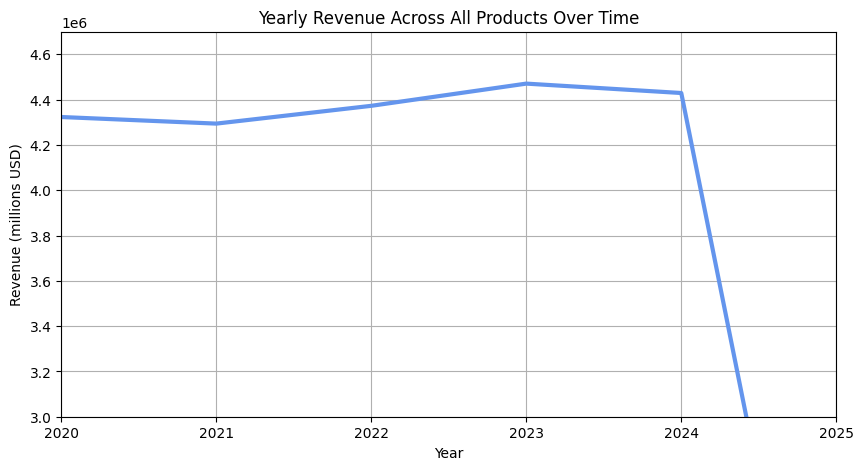

In [235]:
# Yearly Revenue Plot
plt.figure(figsize=(10, 5))
revenue_grouped_by_year.plot(kind='line', color='cornflowerblue', linewidth=3)
plt.title('Yearly Revenue Across All Products Over Time')
plt.ylim(3000000, 4700000)
plt.xlim([2020, 2025])
plt.ylabel('Revenue (millions USD)')
plt.xlabel('Year')
plt.grid(True)

I then analyzed revenue by category. The top category by revenue is Vitamin, followed by Mineral and Performance.

In [236]:
grouped_by_category = dataset.groupby('Category')
revenue_grouped_by_category = grouped_by_category['Revenue'].sum()

revenue_grouped_by_category.sort_values(ascending=False)

Category
Vitamin        4300224.68
Mineral        4276107.99
Performance    2909702.18
Protein        2855492.09
Amino Acid     1464819.63
Omega          1451065.87
Fat Burner     1440900.05
Hydration      1411951.38
Herbal         1405700.79
Sleep Aid      1397315.79
Name: Revenue, dtype: float64

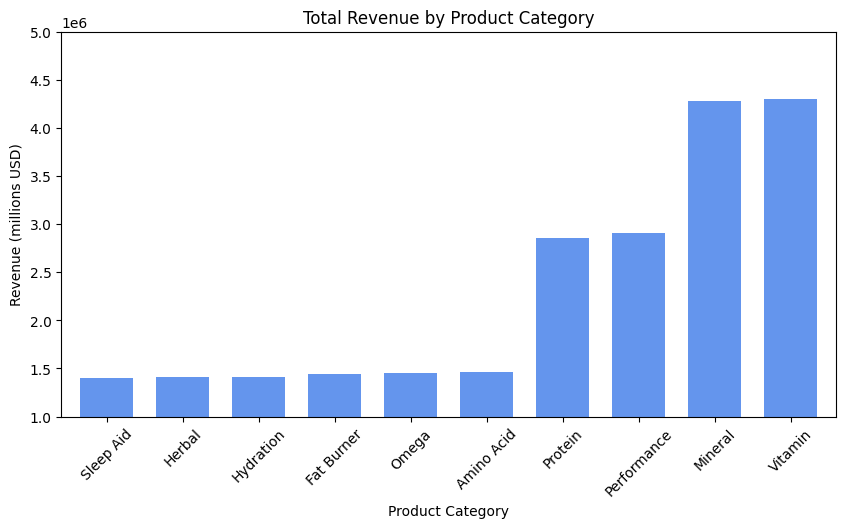

In [237]:
plt.figure(figsize=(10, 5))  
revenue_grouped_by_category.sort_values().plot(kind='bar',x='Category', y='Revenue', color='cornflowerblue', width=0.7)                              
plt.title('Total Revenue by Product Category')                                                                
plt.xlabel('Product Category')                                                                                
plt.ylabel('Revenue (millions USD)')
plt.xticks(rotation=45)                                                                                
plt.ylim(1000000, 5000000);

If we group the same data by sales (Units Sold), the list becomes slightly different: first place is Minerals, second Vitamins, third Performance. 

In [238]:
grouped_by_category['Units Sold'].sum().sort_values(ascending=False)

Category
Mineral        123668
Vitamin        123434
Performance     82523
Protein         82120
Herbal          41408
Omega           41325
Sleep Aid       41165
Hydration       41065
Amino Acid      41027
Fat Burner      40743
Name: Units Sold, dtype: int64

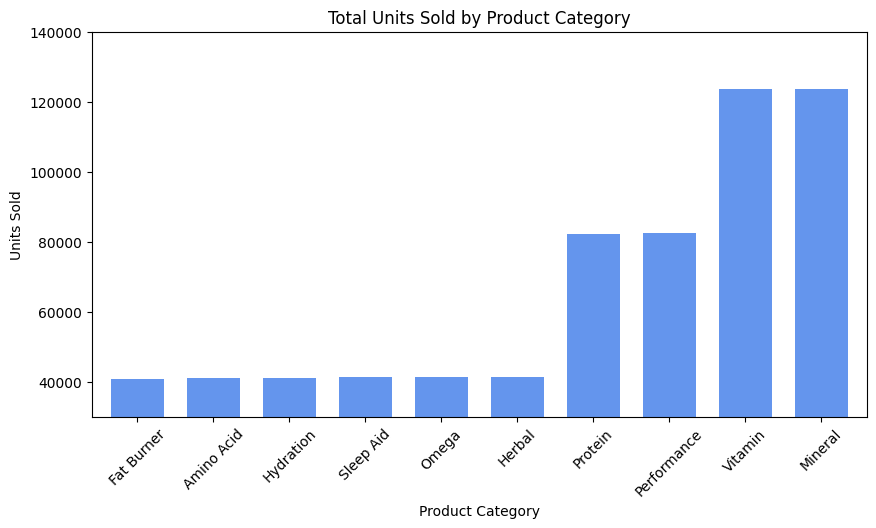

In [239]:
plt.figure(figsize=(10, 5))
grouped_by_category['Units Sold'].sum().sort_values().plot(kind='bar', x='Category', y='Units Sold', color='cornflowerblue', width=0.7)

plt.title('Total Units Sold by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Units Sold')
plt.xticks(rotation=45)
plt.ylim(30000, 140000);

To determine the top-selling product overall, I grouped the data by Product Name. The best-selling product with the highest revenue is Biotin. I will investigate this product further and perform time series analysis in the next section. 

In [240]:
grouped_by_product = dataset.groupby('Product Name')
revenue_grouped_by_product = grouped_by_product['Revenue'].sum().sort_values(ascending=False)
revenue_grouped_by_product

Product Name
Biotin                1486798.62
Zinc                  1482546.95
Pre-Workout           1477183.78
BCAA                  1464819.63
Fish Oil              1451065.87
Green Tea Extract     1440900.05
Collagen Peptides     1433297.24
Creatine              1432518.40
Iron Supplement       1431582.41
Whey Protein          1422194.85
Vitamin C             1421998.07
Electrolyte Powder    1411951.38
Ashwagandha           1405700.79
Melatonin             1397315.79
Multivitamin          1391427.99
Magnesium             1361978.63
Name: Revenue, dtype: float64

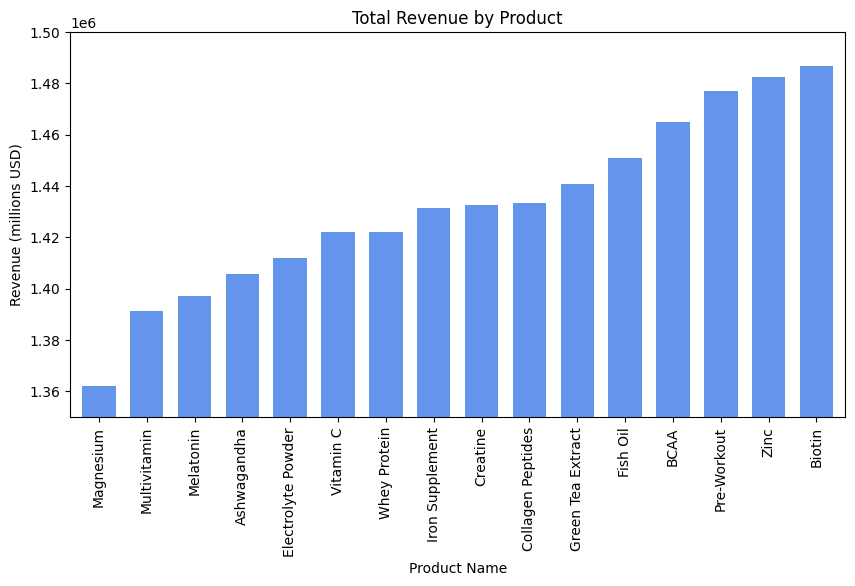

In [241]:
plt.figure(figsize=(10, 5)) 
revenue_grouped_by_product.sort_values().plot(kind='bar',x='Product Name', y='Revenue', color='cornflowerblue', width=0.7)                         
plt.title('Total Revenue by Product')                
plt.xlabel('Product Name')                                                                           
plt.ylabel('Revenue (millions USD)')
plt.ylim(1350000, 1500000);

In [242]:
sales_grouped_by_product = grouped_by_product['Units Sold'].sum().sort_values(ascending=False)
sales_grouped_by_product

Product Name
Biotin                41533
Ashwagandha           41408
Fish Oil              41325
Pre-Workout           41287
Magnesium             41270
Whey Protein          41264
Creatine              41236
Zinc                  41204
Iron Supplement       41194
Multivitamin          41174
Melatonin             41165
Electrolyte Powder    41065
BCAA                  41027
Collagen Peptides     40856
Green Tea Extract     40743
Vitamin C             40727
Name: Units Sold, dtype: int64

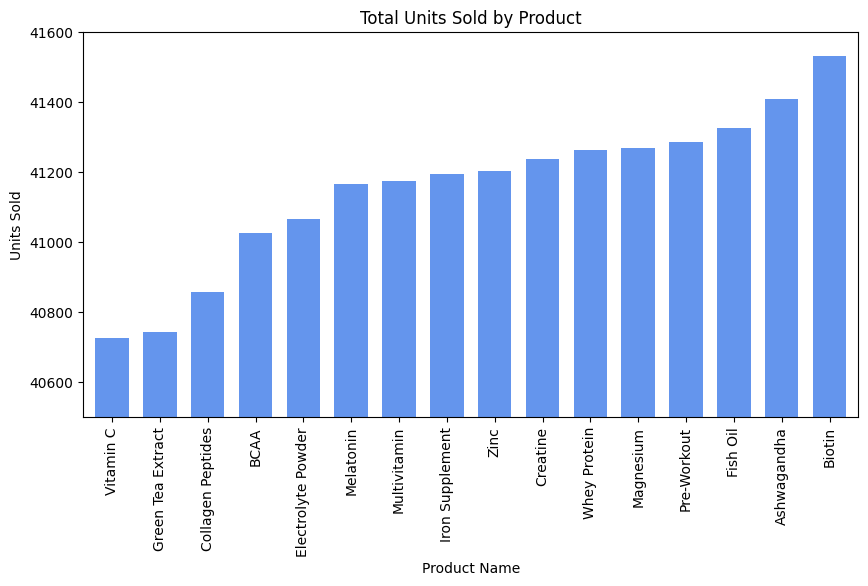

In [243]:
plt.figure(figsize=(10, 5))
sales_grouped_by_product.sort_values().plot(kind='bar',x='Product Name', y='Units Sold', color='cornflowerblue', width=0.7)
plt.title('Total Units Sold by Product')
plt.xlabel('Product Name')
plt.ylabel('Units Sold')
plt.ylim(40500, 41600);

### Correlation

Finally, I conducted correlation analysis to understand the relationships between variables. Most variables show weak positive (or negative) correlation or no correlation, with two notable exceptions:  
* Revenue and Units Sold (correlation = 0.21)
* Revenue and Price (correlation = 0.98)

The strong correlation between revenue and price is expected, since revenue is calculated as Units Sold × Price. 

In [244]:
columns_7 = ['Units Sold', 'Price', 'Revenue','Discount', 'Units Returned', 'Month', 'Year']
subset_7 = dataset[columns_7]
print(round(subset_7.corr(), 2))

                Units Sold  Price  Revenue  Discount  Units Returned  Month  \
Units Sold            1.00   0.01     0.21     -0.01            0.12  -0.00   
Price                 0.01   1.00     0.98     -0.01           -0.01   0.01   
Revenue               0.21   0.98     1.00     -0.01            0.01   0.01   
Discount             -0.01  -0.01    -0.01      1.00            0.00   0.03   
Units Returned        0.12  -0.01     0.01      0.00            1.00   0.02   
Month                -0.00   0.01     0.01      0.03            0.02   1.00   
Year                  0.02  -0.00     0.00      0.04            0.01  -0.12   

                Year  
Units Sold      0.02  
Price          -0.00  
Revenue         0.00  
Discount        0.04  
Units Returned  0.01  
Month          -0.12  
Year            1.00  


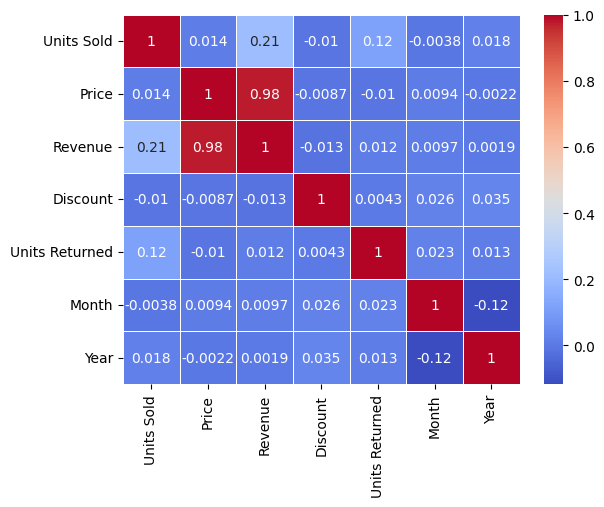

In [245]:
# Heatmap
sns.heatmap(subset_7.corr(), annot=True, cmap='coolwarm', linewidth=0.5);

## 4. Time Series Analysis of Biotin

Earlier, I identified that the best-selling product with the highest revenue is Biotin. In this section, I explore Biotin’s data in detail, prepare it for modeling, choose an appropriate forecasting model, and generate predictions for the next 52 weeks.

In [ ]:
biotin_data = dataset[dataset['Product Name'] == 'Biotin'].copy()
biotin_data

,Product Name,Category,Units Sold,Price,Revenue,Discount,Units Returned,Location,Platform,Month,Year
Date,,,,,,,,,,,
2020-01-06,Biotin,Vitamin,159,28.79,4577.61,0.10,1,UK,iHerb,1,2020
2020-01-13,Biotin,Vitamin,161,18.87,3038.07,0.14,5,USA,iHerb,1,2020
2020-01-20,Biotin,Vitamin,161,32.01,5153.61,0.04,1,Canada,Amazon,1,2020
2020-01-27,Biotin,Vitamin,154,15.70,2417.80,0.04,1,UK,Walmart,1,2020
2020-02-03,Biotin,Vitamin,162,58.36,9454.32,0.10,5,UK,Amazon,2,2020
...,...,...,...,...,...,...,...,...,...,...,...
2025-03-03,Biotin,Vitamin,142,16.41,2330.22,0.19,2,Canada,Walmart,3,2025
2025-03-10,Biotin,Vitamin,145,37.16,5388.20,0.08,2,UK,iHerb,3,2025
2025-03-17,Biotin,Vitamin,134,44.68,5987.12,0.12,2,UK,iHerb,3,2025


In [247]:
biotin_data.index

DatetimeIndex(['2020-01-06', '2020-01-13', '2020-01-20', '2020-01-27',
               '2020-02-03', '2020-02-10', '2020-02-17', '2020-02-24',
               '2020-03-02', '2020-03-09',
               ...
               '2025-01-27', '2025-02-03', '2025-02-10', '2025-02-17',
               '2025-02-24', '2025-03-03', '2025-03-10', '2025-03-17',
               '2025-03-24', '2025-03-31'],
              dtype='datetime64[ns]', name='Date', length=274, freq=None)

In [248]:
biotin_data.describe()

,Units Sold,Price,Revenue,Discount,Units Returned,Month,Year
count,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000
mean,151.580292,35.732080,5426.272336,0.121131,1.500000,6.284672,2022.149635
std,12.657033,13.747568,2172.789134,0.071066,1.229223,3.501855,1.524963
min,114.000000,10.060000,1428.920000,0.000000,0.000000,1.000000,2020.000000
25%,143.000000,25.462500,3828.885000,0.060000,1.000000,3.000000,2021.000000
50%,151.000000,36.390000,5349.830000,0.110000,1.000000,6.000000,2022.000000
75%,160.000000,46.777500,7039.822500,0.190000,2.000000,9.000000,2023.000000
max,186.000000,59.970000,9807.370000,0.250000,6.000000,12.000000,2025.000000


In [249]:
biotin_data.isna().sum()

Product Name      0
Category          0
Units Sold        0
Price             0
Revenue           0
Discount          0
Units Returned    0
Location          0
Platform          0
Month             0
Year              0
dtype: int64

In [250]:
biotin_weekly_sales = biotin_data['Units Sold']
biotin_weekly_sales

Date
2020-01-06    159
2020-01-13    161
2020-01-20    161
2020-01-27    154
2020-02-03    162
             ... 
2025-03-03    142
2025-03-10    145
2025-03-17    134
2025-03-24    150
2025-03-31    154
Name: Units Sold, Length: 274, dtype: int64

#### Stationarity Check & Model Selection (ARIMA vs. SARIMA)

For Time Series Analysis, I choose between ARIMA (AutoRegressive Integrated Moving Average) and SARIMA (Seasonal ARIMA) models. It depends on whether Biotin sales show a trend and seasonality or not. ARIMA and SARIMA are widely used in retail for analyzing past sales data and producing reliable forecasts. In ARIMA:
* AR (autoregressive) part (parameter ‘p’) models how past values influence the current value.
* I (integrated) part (‘d’) uses differencing to make the data stable over time (stationary).
* MA (moving average) part (‘q’) models how past errors affect current values.
* SARIMA adds seasonal parameters (P, D, Q, s) to capture repeating patterns such as yearly cycles.

To check for trend and seasonality, I plotted Biotin’s weekly sales over time. The data was highly variable, making patterns difficult to see.

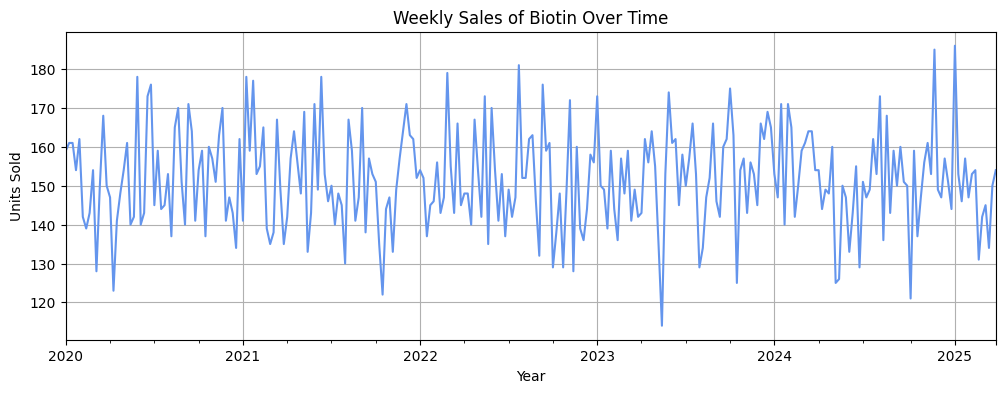

In [251]:
# Weekly Biotin Sales
plt.figure(figsize=(12, 4))
biotin_weekly_sales.plot(color='cornflowerblue')
plt.title('Weekly Sales of Biotin Over Time')
plt.ylabel('Units Sold')
plt.xlabel('Year')
plt.grid(True)

I performed decomposition analysis by aggregating weekly sales data by months to eliminate noise and enhance the detection of trends and seasonal patterns. 
* On the original plot, we can see monthly time series with recurring peaks and dips, which suggests seasonal patterns.
* The next plot indicates non-random behavior over time, which means that a trend exists. The trend line is relatively stable, but has some not dramatic increases and decreases over the years.
* The seasonal plot demonstrates a very clear and repetitive seasonal cycle with a period of 12 months. This is strong evidence that the Biotin sales have a yearly pattern. For example, it has demand spikes in certain months. 
* Plot with residual component shows the departure from the expected value for each month, which means it represents the variations that are not explained by trend or seasonality.

In [252]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition_biotin_months = seasonal_decompose(biotin_data['Units Sold'].resample('ME').sum(), model='additive', period=12)

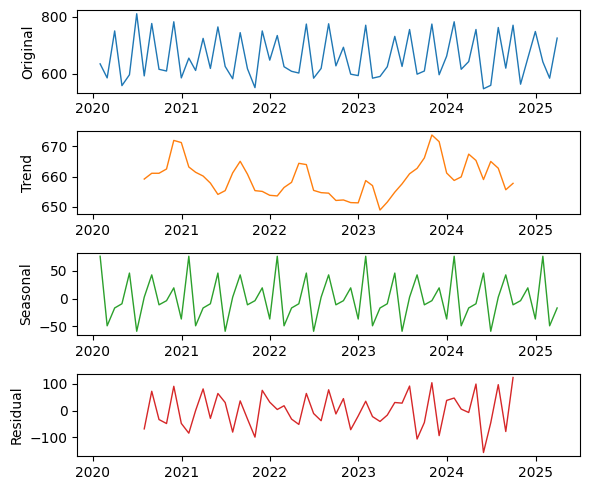

In [253]:
plot_decomposition(biotin_data['Units Sold'].resample('ME').sum(), decomposition_biotin_months)

Biotin sales have seasonality, trend, and predictable monthly fluctuations. The best model to choose will be SARIMA, because the ARIMA model will ignore seasonality, and in the result, the forecast will be misleading. 

The next step is to determine model parameters. In the SARIMA model, we need to identify the parameters of the non-seasonal part (p, d, q) and the parameters of the seasonal part (P, D, Q, s). We already know that the ‘s’ value equals 52 because weekly data has a yearly repetitive cycle (52 weeks). To recognize other values, I used the Augmented Dickey-Fuller Test, ACF (Autocorrelation Function), and PACF (Partial Autocorrelation Function).

##### Check Stationarity Using Augmented Dickey-Fuller Test

Here I performed the Augmented Dickey-Fuller test to check the stationarity. Stationarity guarantees that the statistical properties of a time series, such as mean and variance, remain constant. Non-stationary data, often showing trends or seasonal patterns, can misrepresent predictions. In this case, the series requires differencing to remove trends and seasonality. However, in my case, the data is stationary. It means that in the order (p, d, q), ‘d’ equals 0.

In [254]:
from statsmodels.tsa.stattools import adfuller

result_adfuller = adfuller(biotin_weekly_sales)

print(f'ADF Statistic (Original): {result_adfuller[0]:.4f}')
print(f'p-value (Original): {result_adfuller[1]:.4f}')

if result_adfuller[1] < 0.05:
    print('Interpretation: The original series is Stationary -> d=0\n')
else:
    print('Interpretation: The original series is Non-Stationary -> consider differencing (d=1)\n')

ADF Statistic (Original): -16.0314
p-value (Original): 0.0000
Interpretation: The original series is Stationary -> d=0



##### Check Autocorrelation with ACF and PACF

To identify the remaining parameters (p, 0, q) and (P, D, Q, 52), I used ACF and PACF plots. The lag where ACF cuts off suggests the MA part (q) and where PACF cuts off suggests the AR part (p).

The plots show significant spikes at the first lag, then autocorrelations drop quickly and remain within the confidence band. This suggests a low Moving Average (MA) and low Autoregressive (AR) orders, so q = 0 or 1 and p = 0 or 1. For seasonal order, because of seasonality, I chose this order (1, 1, 1, 52). I tested different SARIMA parameters and evaluated them (see Appendix). The goal was to find the model with the smallest parameters of tests and errors such as AIC/BIC criteria, MAE (Mean Absolute Error), RMSE (Root Mean Squared Error), and MAPE (Mean Absolute Percentage Error).

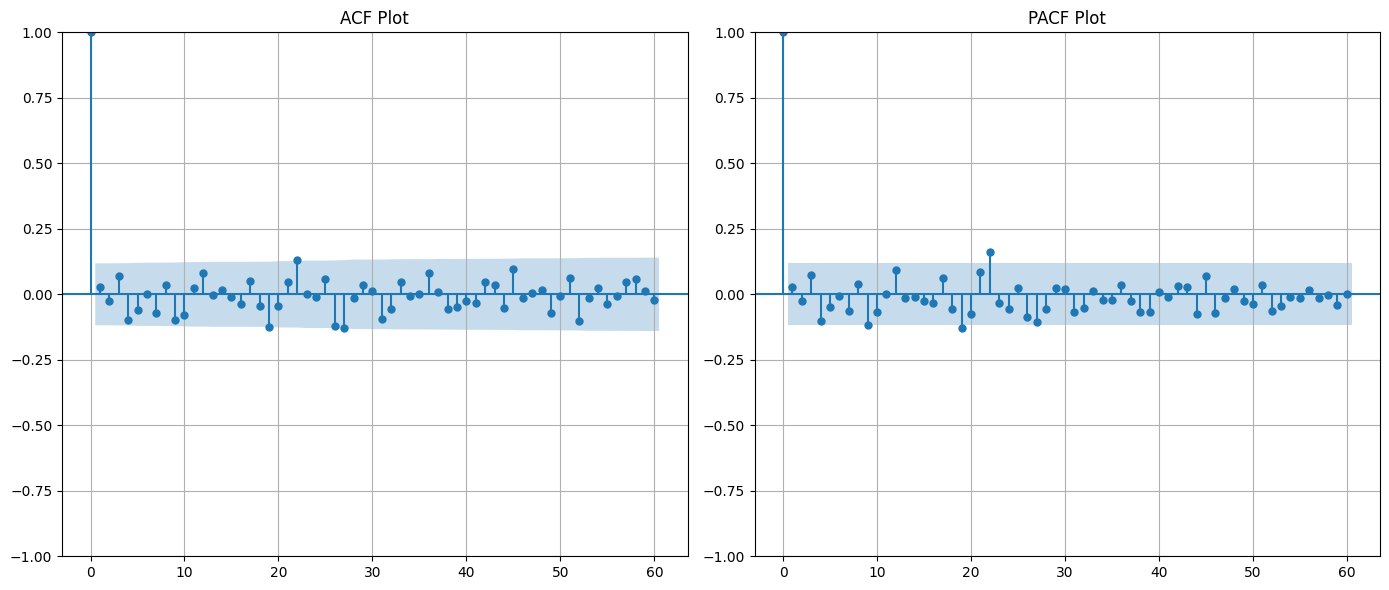

In [255]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(14, 6))

# ACF plot (for MA component - q)
plt.subplot(1, 2, 1)
plot_acf(biotin_weekly_sales, lags=60, ax=plt.gca(), title='ACF Plot')
plt.grid(True)

# PACF plot (for AR component - p)
plt.subplot(1, 2, 2)
plot_pacf(biotin_weekly_sales, lags=60, ax=plt.gca(), title='PACF Plot')

plt.grid(True)
plt.tight_layout()

#### Modeling with SARIMA

The two best candidates were with order=(1, 0, 0), seasonal_order=(1, 1, 1, 52) and order=(1, 0, 1), seasonal_order=(1, 1, 1, 52). I evaluated both using two train/test splits (52-week and 60-week test periods). The second configuration — order=(1, 0, 1), seasonal_order=(1, 1, 1, 52) — performed best and was selected for forecasting.

##### Train/Test Split

The final model was trained on 214 weeks of data and tested on 60 weeks, with the split date set to February 12, 2024.

In [256]:
split_date = '2024-02-12'
train_sarima_biotin = biotin_data[biotin_data.index < split_date]['Units Sold'].resample('W-MON').sum()
test_sarima_biotin = biotin_data[biotin_data.index >= split_date]['Units Sold'].resample('W-MON').sum()

# Check shape
train_sarima_biotin.shape, test_sarima_biotin.shape

((214,), (60,))

Here I computed a SARIMA model with chosen parameters and evaluated this model using AIC/BIC criteria (Akaike/Bayesian Information Criteria). The value of AIC is 1361 and BIC is 1377. 

In [257]:
from statsmodels.tsa.statespace.sarimax import SARIMAX 
import statsmodels.tsa.api as tsa

# Fit SARIMA model (p, d, q, P, D, Q, s)
model_sarima_biotin_units = SARIMAX(train_sarima_biotin, order=(1, 0, 1), seasonal_order=(1, 1, 1, 52))

results_sarima_biotin = model_sarima_biotin_units.fit()

/Users/anastasiiiapo/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/anastasiiiapo/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/anastasiiiapo/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.26770D+00    |proj g|=  1.35952D-01

At iterate    5    f=  3.19942D+00    |proj g|=  2.58157D-02

At iterate   10    f=  3.16609D+00    |proj g|=  4.11556D-02

At iterate   15    f=  3.16196D+00    |proj g|=  6.12147D-04

At iterate   20    f=  3.16099D+00    |proj g|=  2.26650D-02

At iterate   25    f=  3.15822D+00    |proj g|=  5.16937D-03

At iterate   30    f=  3.15808D+00    |proj g|=  3.04505D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

In [ ]:
print(results_sarima_biotin.aic, results_sarima_biotin.bic)

1361.6585215409182 1377.09650321708


I made a forecast for test data.

In [ ]:
forecast_biotin = results_sarima_biotin.get_forecast(steps=len(test_sarima_biotin))
predicted_mean_biotin = forecast_biotin.predicted_mean
conf_int_biotin = forecast_biotin.conf_int()
conf_int_biotin.columns = ['lower', 'upper']

In [260]:
predicted_mean_biotin

2024-02-12    145.524356
2024-02-19    146.798110
2024-02-26    155.694233
2024-03-04    145.983425
2024-03-11    150.399464
2024-03-18    159.793669
2024-03-25    142.282297
2024-04-01    145.726891
2024-04-08    147.040982
2024-04-15    149.496907
2024-04-22    159.324438
2024-04-29    152.507163
2024-05-06    152.737430
2024-05-13    146.819769
2024-05-20    141.094456
2024-05-27    172.510156
2024-06-03    150.548719
2024-06-10    154.963138
2024-06-17    156.043709
2024-06-24    150.458324
2024-07-01    148.581423
2024-07-08    146.921473
2024-07-15    149.178341
2024-07-22    159.404248
2024-07-29    142.760286
2024-08-05    150.873754
2024-08-12    159.752450
2024-08-19    156.595883
2024-08-26    149.967039
2024-09-02    146.540915
2024-09-09    159.418959
2024-09-16    159.581754
2024-09-23    154.674112
2024-09-30    146.645764
2024-10-07    144.769028
2024-10-14    135.131401
2024-10-21    143.058275
2024-10-28    151.134847
2024-11-04    152.480598
2024-11-11    145.043974


To evaluate the model, I visualized the results of the forecast and actual values of Biotin weekly sales observed in the test. The train data (blue line) covers historical values. The forecasted values (green line) show the model’s weekly prediction, while the actual data (orange line) represents the real sales at the same period as the forecasted data. The shaded green area is the 95% confidence interval, which indicates the range where true forecast values are likely to fall with 95% certainty. Forecasted values cover trends and seasonal values of sales but don’t capture some extra spikes and dips; however, the overall result is quite good. 

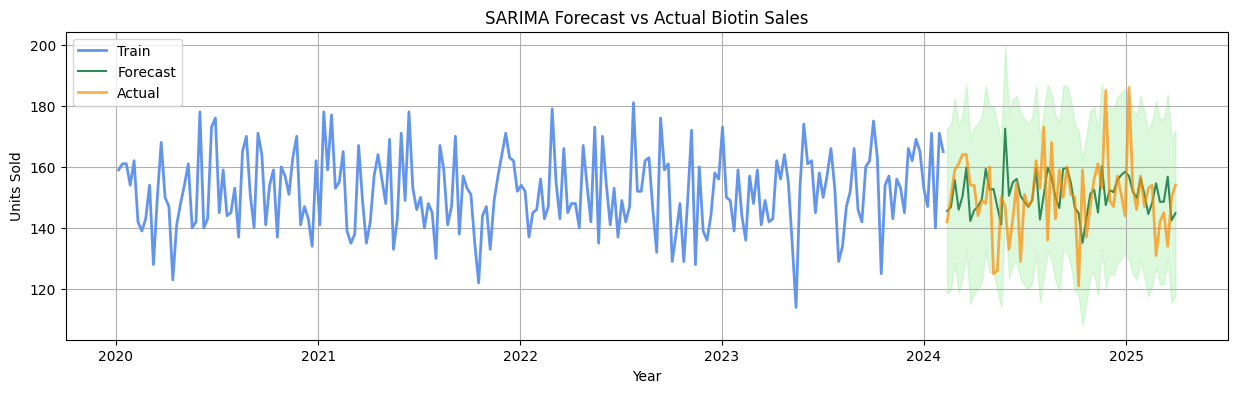

In [261]:
# Actual vs Forecasted Sales of Biotin
plt.figure(figsize=(15, 4))
plt.plot(train_sarima_biotin.index, train_sarima_biotin, label='Train', color='cornflowerblue', lw=2)
plt.plot(predicted_mean_biotin.index, predicted_mean_biotin, label='Forecast', color='seagreen', ls='-', alpha=1)
plt.plot(test_sarima_biotin.index, test_sarima_biotin, label='Actual', color='darkorange', alpha=0.7, lw=2)

plt.fill_between(conf_int_biotin.index, conf_int_biotin.lower, conf_int_biotin.upper, color='lightgreen', alpha=0.3)
plt.title('SARIMA Forecast vs Actual Biotin Sales')
plt.xlabel('Year')
plt.ylabel('Units Sold')
plt.legend()
plt.grid(True);

##### Forecast Accuracy Evaluation

Then I evaluated forecast accuracy using three standard error metrics: MAE (Mean Absolute Error), RMSE (Root Mean Squared Error), and MAPE (Mean Absolute Percentage Error). MAE equals 10.12, which means that predictions are, on average, off by approximately 10 units sold per week. RMSE equals 13.40, slightly higher than MAE but close, suggesting no extreme outliers in prediction errors.

In [ ]:
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(test_sarima_biotin, predicted_mean_biotin)
rmse = np.sqrt(mean_squared_error(test_sarima_biotin, predicted_mean_biotin))

print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')

MAE: 10.12
RMSE: 13.40


MAPE equals 6.84%, which means predictions are off by 7% on average. This indicates good accuracy because the average weekly sales volume is about 151 units.

In [263]:
mape = MAPE(predicted_mean_biotin, test_sarima_biotin)

print(f'MAPE: {mape:.2f}')

MAPE: 6.84


#### 52-Week Sales Forecast

Finally, I retrained the SARIMA model on the entire dataset and forecasted Biotin’s sales for the next 52 weeks beyond March 31, 2025. 

In [ ]:
# Fit SARIMA on full data
final_model_biotin = SARIMAX(biotin_data['Units Sold'].resample('W-MON').sum(), order=(1, 0, 1), seasonal_order=(1, 1, 1, 52))
final_results_biotin = final_model_biotin.fit()

# Forecast next 52 weeks
future_forecast_biotin = final_results_biotin.get_forecast(steps=52)
future_index_biotin = pd.date_range(start=biotin_data['Units Sold'].resample('W-MON').sum().index[-1] + pd.Timedelta(weeks=1), periods=52, freq='W-MON')
future_pred_biotin = future_forecast_biotin.predicted_mean
future_conf_int_biotin = future_forecast_biotin.conf_int()
future_conf_int_biotin.columns = ['lower', 'upper']

/Users/anastasiiiapo/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/anastasiiiapo/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.47278D+00    |proj g|=  1.87926D-01


 This problem is unconstrained.



At iterate    5    f=  3.40924D+00    |proj g|=  8.14673D-02

At iterate   10    f=  3.38982D+00    |proj g|=  7.42405D-02

At iterate   15    f=  3.34860D+00    |proj g|=  5.37830D-03

At iterate   20    f=  3.34854D+00    |proj g|=  1.71113D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     25      1     0     0   2.468D-05   3.349D+00
  F =   3.3485413105114405     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


The plot demonstrates historical data, forecasted data, and a 95% confidence interval.

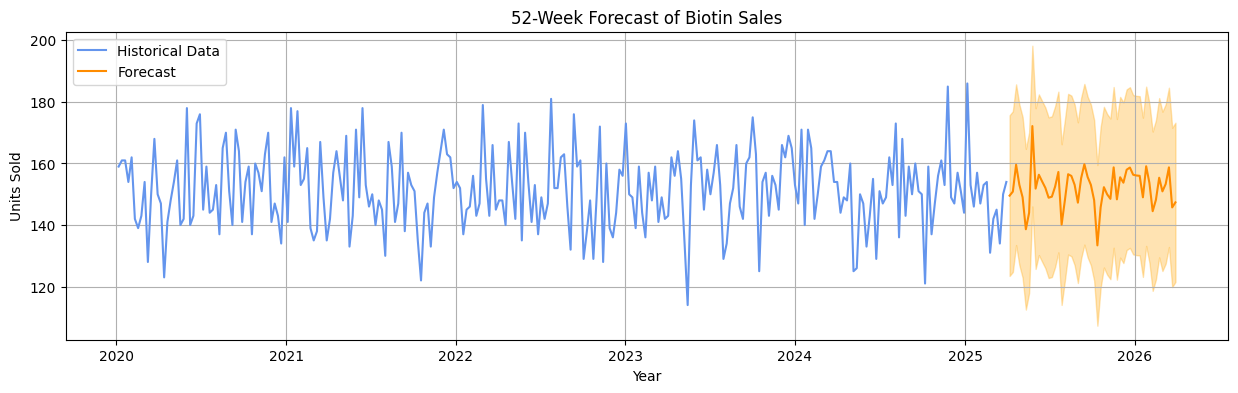

In [265]:
# Plot forecast
plt.figure(figsize=(15, 4))
plt.plot(biotin_data['Units Sold'].resample('W-MON').sum(), label='Historical Data', color='cornflowerblue')
plt.plot(future_index_biotin, future_pred_biotin, label='Forecast', color='darkorange')
plt.fill_between(future_index_biotin, future_conf_int_biotin.lower, future_conf_int_biotin.upper, color='orange', alpha=0.3)
plt.title('52-Week Forecast of Biotin Sales')
plt.xlabel('Year')
plt.ylabel('Units Sold')
plt.legend()
plt.grid(True)

In [266]:
future_pred_biotin

2025-04-07    149.552906
2025-04-14    150.866394
2025-04-21    159.603967
2025-04-28    153.085407
2025-05-05    149.001808
2025-05-12    138.636400
2025-05-19    143.980824
2025-05-26    172.159568
2025-06-02    151.843315
2025-06-09    156.348221
2025-06-16    154.175941
2025-06-23    152.084932
2025-06-30    148.884015
2025-07-07    149.218905
2025-07-14    152.497979
2025-07-21    157.240670
2025-07-28    140.145905
2025-08-04    148.023225
2025-08-11    156.517346
2025-08-18    155.951355
2025-08-25    153.064035
2025-09-01    147.278560
2025-09-08    155.233777
2025-09-15    159.747962
2025-09-22    155.603910
2025-09-29    153.053132
2025-10-06    148.053092
2025-10-13    133.396065
2025-10-20    145.753757
2025-10-27    152.302790
2025-11-03    149.983956
2025-11-10    148.512370
2025-11-17    158.742582
2025-11-24    148.352757
2025-12-01    155.524109
2025-12-08    153.760619
2025-12-15    157.975895
2025-12-22    158.688377
2025-12-29    156.338937
2026-01-05    156.099338


The plots present both weekly and monthly sales forecasts to make the results easier to interpret.

In [267]:
future_pred_biotin.resample('ME').sum()

2025-04-30    613.108673
2025-05-31    603.778599
2025-06-30    763.336423
2025-07-31    599.103460
2025-08-31    613.555961
2025-09-30    770.917340
2025-10-31    579.505704
2025-11-30    605.591664
2025-12-31    782.287938
2026-01-31    620.202524
2026-02-28    601.743841
2026-03-31    756.125751
Freq: ME, Name: predicted_mean, dtype: float64

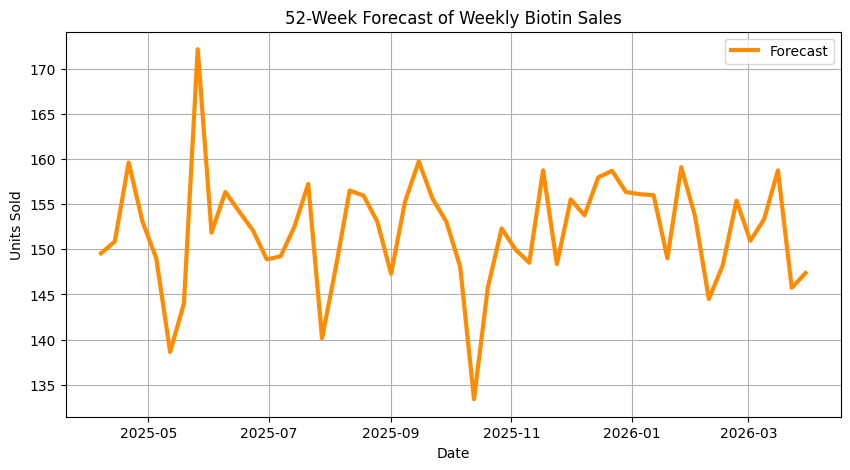

In [268]:
plt.figure(figsize=(10, 5))
plt.plot(future_index_biotin, future_pred_biotin, label='Forecast', color='darkorange', linewidth=3)
plt.title('52-Week Forecast of Weekly Biotin Sales')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.grid(True);

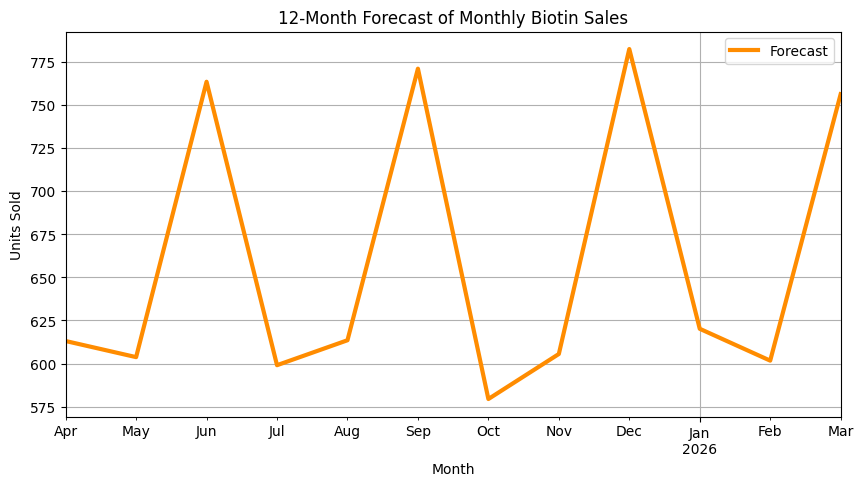

In [269]:
plt.figure(figsize=(10, 5))
future_pred_biotin.resample('ME').sum().plot(label='Forecast', color='darkorange', linewidth=3)

plt.title('12-Month Forecast of Monthly Biotin Sales')
plt.xlabel('Month')
plt.ylabel('Units Sold')
plt.legend()
plt.grid(True);

## 5. Conclusion

Exploratory data analysis (EDA) was performed on a dataset containing weekly sales of health supplements from January 2020 through March 2025. The analysis identified Biotin as the best-selling product with the highest revenue. A SARIMA (Seasonal ARIMA) time series model was used to forecast Biotin’s future sales.

Biotin's sales displayed clear seasonality and a stable trend, making SARIMA an appropriate choice for forecasting. After testing multiple parameter configurations and evaluating performance with AIC, BIC, MAE, RMSE, and MAPE, the best model was selected with order (1, 0, 1) and seasonal order (1, 1, 1, 52). This model was trained on 214 weeks of data and tested on 60 weeks. It showed strong predictive accuracy (MAE = 10.12, RMSE = 13.40, and MAPE = 6.84%). This model was then used to forecast Biotin’s weekly sales for the next 52 weeks beyond March 31, 2025, with results presented at both weekly and monthly levels. These forecasts can help with inventory planning, marketing strategy, and supply chain optimization.

Future work may involve further model optimization to reduce error metrics and improve forecast accuracy. Additionally, analyzing the causes of extreme weekly sales spikes and dips — such as promotions, stockouts, or special events — would enhance understanding of demand volatility and lead to more robust forecasting.

## 6. Appendix A – SARIMA Model Comparison

| Model Order (p,d,q) | Seasonal Order (P,D,Q,s) | Forecast Horizon | MAE   | RMSE  | MAPE (%) | AIC    | BIC    | Notes |
|---------------------|--------------------------|------------------|-------|-------|-----------|--------|--------|-------|
| (1,0,1)             | (1,1,1,52)               | 60 weeks         | 10.12 | 13.40 | 6.84      | 1361.7 | 1377.1 | ✅ Selected model (best balance of metrics) |
| (1,0,0)             | (1,1,1,52)               | 60 weeks         | 10.20 | 13.42 | 6.89      | 1361.3 | 1373.6 | Close to best |
| (1,0,0)             | (1,1,1,52)               | 52 weeks         | 10.49 | 13.99 | 7.14      | 1421.5 | 1434.0 | |
| (1,0,1)             | (1,1,1,52)               | 52 weeks         | 10.50 | 13.99 | 7.15      | 1421.5 | 1437.2 | |
| (0,0,0)             | (1,1,1,52)               | 52 weeks         | 10.49 | 13.99 | 7.14      | 1419.6 | 1429.0 | |
| (0,0,1)             | (1,1,1,52)               | 52 weeks         | 10.49 | 13.99 | 7.14      | 1421.5 | 1434.1 | |
| (1,0,1)             | (0,1,1,52)               | 52 weeks         | 10.95 | 14.27 | 7.45      | 1423.0 | 1435.6 | |
| (1,0,0)             | (0,1,1,52)               | 52 weeks         | 10.96 | 14.28 | 7.46      | 1423.6 | 1433.0 | |
| (1,0,1)             | (1,0,1,52)               | 52 weeks         | 10.48 | 13.90 | 7.28      | 1780.8 | 1797.8 | |
| (1,0,1)             | (1,1,0,52)               | 52 weeks         | 11.86 | 15.36 | 7.97      | 1427.5 | 1440.0 | |
| (1,1,1)             | (1,1,1,52)               | 52 weeks         | 11.09 | 14.50 | 7.62      | 1422.0 | 1437.6 | |
| (1,0,1)             | (0,0,0,52)               | 52 weeks         |  9.25 | 12.87 | 6.35      | 1772.0 | 1782.2 | Flat forecast, unrealistic |
| (1,0,1)             | (0,1,0,52)               | 52 weeks         | 15.92 | 19.18 | 10.75     | 1484.8 | 1494.2 | |
| (0,0,0)             | (1,0,0,52)               | 52 weeks         | 15.66 | 18.87 | 10.54     | 2156.7 | 2163.4 | Used Auto ARIMA |
| (0,1,0)             | (1,1,0,52)               | 52 weeks         | 15.24 | 18.23 | 10.45     | 1532.0 | 1538.3 | Used Auto ARIMA |